In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import scvelo as scv
import scanpy.external as sce
import os,re
import copy
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import dynamo as dyn

from statannot import add_stat_annotation

sc.settings.set_figure_params(dpi=60, frameon=False, figsize=(3, 3), facecolor='white')
scv.settings.set_figure_params(dpi=60)

sc.settings.verbosity = 3 
sc.logging.print_versions()

sns.set_style({'axes.grid' : False})
#plt.rcParams['font.sans-serif']=['Arial']

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.
-----
anndata     0.8.0
scanpy      1.9.1
-----
KDEpy               1.1.0
PIL                 8.2.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
bottleneck          1.3.2
cffi                1.14.6
cloudpickle         1.6.0
colorcet            3.0.0
cutils              NA
cvxopt              1.3.0
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.07.2
dateutil            2.8.1
decorator           5.0.9
dynamo              1.1.0
fsspec              2021.07.0
google              NA
h5py                3.7.0
igraph              0.9.6
ipykernel           6.1.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
joblib              1.0.1
kiwisolver          1.3.1
leidenalg           0.8.8
llvmlite            0.39.1
louvain             0.7.0
matplotlib          3.6.1
matplotlib_

In [2]:
dyn.get_all_dependencies_version()

package,pre-commit,colorcet,cvxopt,dynamo-release,get-version,loompy,matplotlib,networkx,numba,numdifftools,numpy,openpyxl,pandas,pynndescent,python-igraph,scikit-learn,scipy,seaborn,setuptools,statsmodels,tqdm,umap-learn
version,2.17.0,3.0.0,1.3.0,1.1.0,3.5.4,3.0.6,3.6.1,2.6.2,0.56.4,0.9.40,1.22.4,3.0.10,1.5.2,0.5.4,0.9.6,1.1.3,1.7.1,0.11.1,52.0.0.post20210125,0.12.2,4.62.3,0.5.2


In [3]:
CD8_LOOM_PATH = "/project_file/velocity_CD8.h5ad"
CD8TEX_LOOM_PATH = "/project_file/velocity_cd8Tex.h5ad"

## CD8
* CD8+ Tem,CD8+ Trm, CD8+ Tex-SPRY1, CD8+ Tex-XAF1 

### RNA velocity (scVelo)

In [4]:
cd8_loom = sc.read_h5ad(CD8_LOOM_PATH)
cd8_loom

AnnData object with n_obs × n_vars = 21712 × 21375
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'total_counts_hb', 'pct_counts_hb', 'total_counts_hsp', 'pct_counts_hsp', 'treat', 'sample', 'treat_sample', 'group', 'sample_batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'cellType'
    var: 'gene_ids', 'feature_types', 'mt', 'rb', 'hb', 'hsp', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'cellType_colors', 'dendrogram_leiden', 'dendrogram_leiden_name_1102', 'dendrogram_leiden_new', 'diffmap_evals', 'hvg', 'leiden', 'leiden_colors', 'leiden_name_1102_colors', 'leiden_name_1104_colors', 'leiden_name_colors', 'leiden_new_colors', 'louvain', 'l

computing Diffusion Maps using n_comps=29(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.92973995 0.9142675  0.90459526 0.88936466 0.86865336
     0.84586805 0.8422387  0.83425754 0.8179196  0.8155328  0.808167
     0.80708295 0.795457   0.7950067  0.7867122  0.77965313 0.7758089
     0.7716981  0.7655257  0.758733   0.7523754  0.74848294 0.7460994
     0.74050105 0.73833656 0.7362975  0.73509914 0.73433393]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:01)


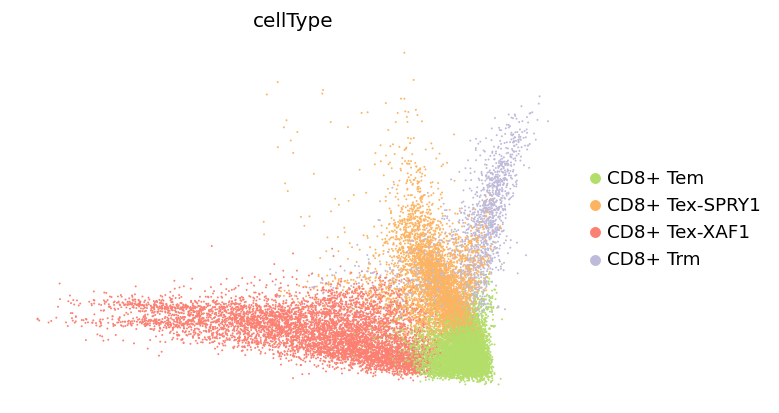

In [5]:
sc.tl.diffmap(cd8_loom,n_comps=29)
sc.pl.diffmap(cd8_loom,components=['2,3'],color='cellType')

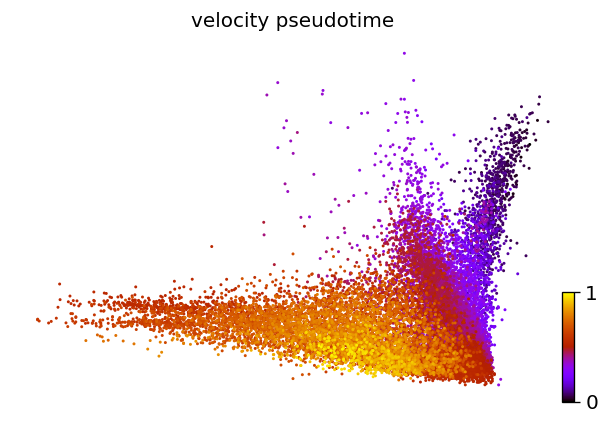

In [23]:
scv.pl.scatter(cd8_loom, color='velocity_pseudotime', cmap='gnuplot',basis ='diffmap')

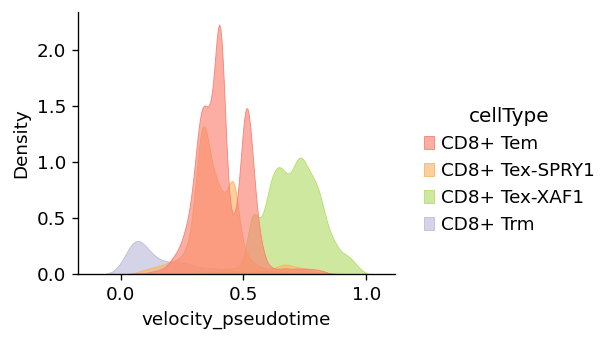

In [37]:
cd8_meta = cd8_loom.obs
sns.displot(cd8_meta, x="velocity_pseudotime", hue="cellType", kind="kde", fill=True,
            palette=list(cd8_loom.uns['cellType_colors'][[2,1,0,3]]),
            alpha=0.64,height=3, aspect=1.2)

In [26]:
cd8_loom2 = sc.read_h5ad(CD8_LOOM_PATH)
cd8_loom2.uns['cellType_colors']

array(['#b3de69', '#fdb462', '#fb8072', '#bebada'], dtype=object)

### Dynamo validation

In [6]:
cd8_loom = sc.read_h5ad(CD8_LOOM_PATH)
cd8_loom

AnnData object with n_obs × n_vars = 21712 × 21375
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'total_counts_hb', 'pct_counts_hb', 'total_counts_hsp', 'pct_counts_hsp', 'treat', 'sample', 'treat_sample', 'group', 'sample_batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'cellType'
    var: 'gene_ids', 'feature_types', 'mt', 'rb', 'hb', 'hsp', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'cellType_colors', 'dendrogram_leiden', 'dendrogram_leiden_name_1102', 'dendrogram_leiden_new', 'diffmap_evals', 'hvg', 'leiden', 'leiden_colors', 'leiden_name_1102_colors', 'leiden_name_1104_colors', 'leiden_name_colors', 'leiden_new_colors', 'louvain', 'l

In [7]:
del cd8_loom.layers['Ms'], cd8_loom.layers['Mu'], cd8_loom.layers['variance_velocity'], cd8_loom.layers['velocity'], cd8_loom.layers['matrix']
dyn.pp.recipe_monocle(cd8_loom, n_top_genes=3000, fg_kwargs={"shared_count": 20})
dyn.tl.dynamics(cd8_loom)
dyn.tl.reduceDimension(cd8_loom, n_pca_components=30)
dyn.tl.cell_velocities(cd8_loom, method="pearson", 
                       other_kernels_dict={"transform": "sqrt"})
dyn.tl.cell_velocities(cd8_loom, basis="pca")

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|----- no mitochondria genes detected; looks like your var_names may be corrupted (i.e. include nan values). If you don't believe so, please report to us on github or via xqiu@wi.mit.edu
Traceback (most recent call last):
  File "/share/home/zhangyr/.conda/envs/web_jupyter/lib/python3.8/site-packages/pandas/core/indexes/base.py", line 3803, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 165, in panda

2022-12-30 16:03:54.735307: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [112.6109s]


estimating gamma: 100%|██████████| 2368/2368 [09:28<00:00,  4.17it/s]


|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.0022s]
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [14.7886s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [4.5729s]
|-----> 0 genes are removed because of nan velocity values.
Using existing pearson_transition_matrix found in .obsp.
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector t

AnnData object with n_obs × n_vars = 21712 × 21375
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'total_counts_hb', 'pct_counts_hb', 'total_counts_hsp', 'pct_counts_hsp', 'treat', 'sample', 'treat_sample', 'group', 'sample_batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'cellType', 'nGenes', 'nCounts', 'pass_basic_filter', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'gene_ids', 'feature_types', 'mt', 'rb', 'hb', 'hsp', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 

In [8]:
cd8_loom.obsm['X_umap'] = cd8_loom.obsm['X_diffmap'][:,1:3]

|-----------> plotting with basis key=X_umap
|-----------> skip filtering cellType by stack threshold when stacking color because it is not a numeric type


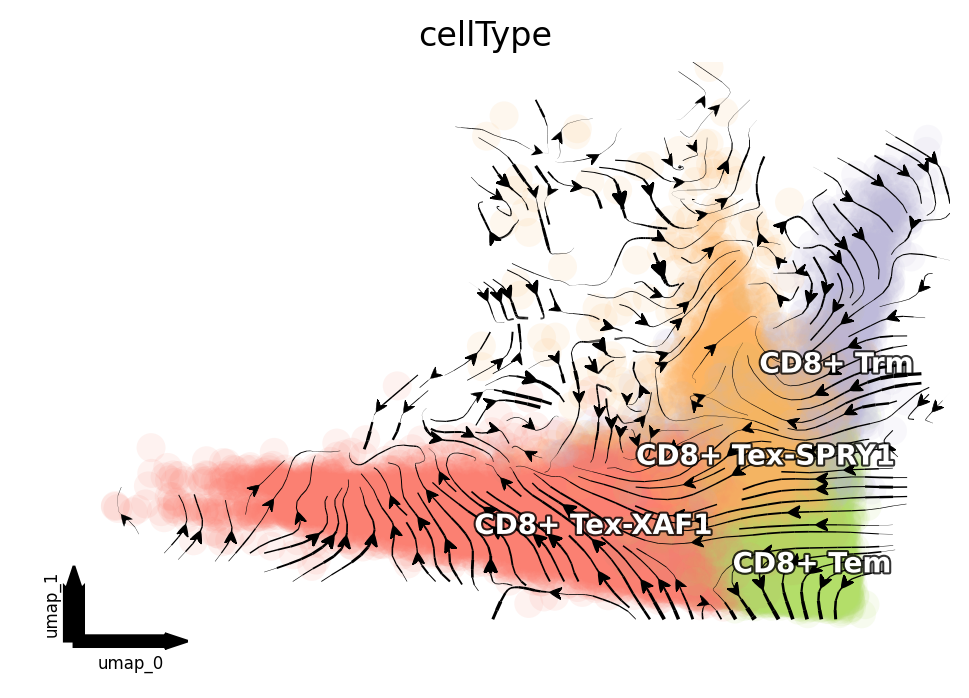

In [28]:
ax = dyn.pl.streamline_plot(cd8_loom, color=["cellType"], layer='X',
                       basis="umap", show_legend="on data", 
                       show_arrowed_spines=True,color_key  = ['#b3de69', '#fdb462', '#fb8072', '#bebada'],
                      save_show_or_return ='return')

In [10]:
dyn.vf.VectorField(cd8_loom, basis='umap', M=1000, pot_curl_div=True)

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [25.4368s]
|-----------> current cosine correlation between input velocities and learned velocities is less than 0.6. Make a 1-th vector field reconstruction trial.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [25.4384s]
|-----------> current cosine correlation between input velocities and learned velocities is less than 0.6. Make a 2-th vector field reconstruction trial.
|-----> [SparseVFC] begins...
|-----> Sampling control

Calculating 2-D curl: 100%|██████████| 21712/21712 [00:01<00:00, 17676.60it/s]

|-----> Computing divergence...



Calculating divergence: 100%|██████████| 22/22 [00:01<00:00, 20.02it/s]

|-----> <insert> control_point_umap to obs in AnnData Object.
|-----> <insert> inlier_prob_umap to obs in AnnData Object.


|-----> <insert> obs_vf_angle_umap to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [187.0961s]


|-----------> plotting with basis key=X_umap


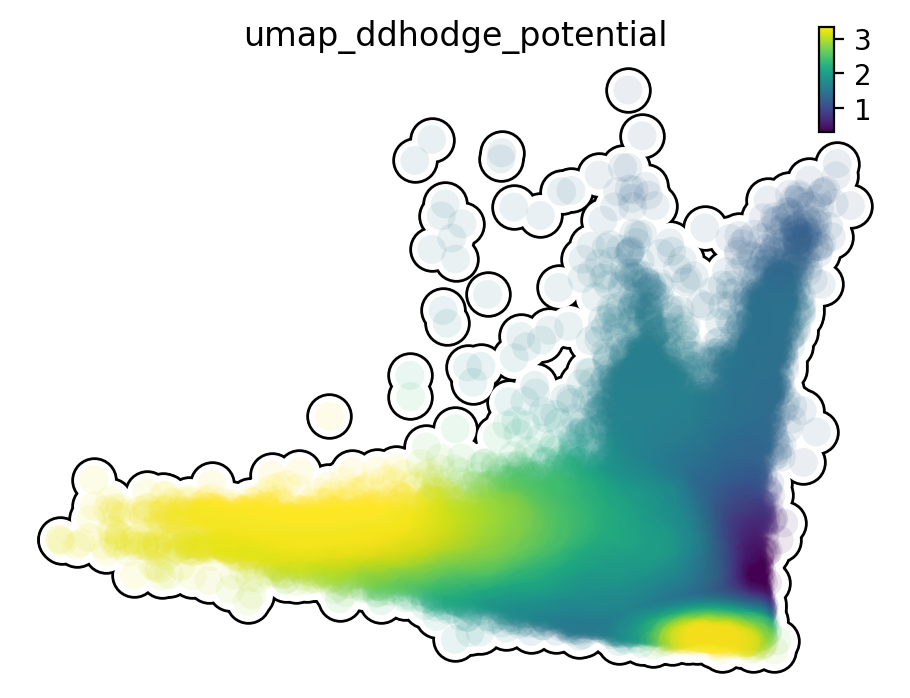

In [11]:
dyn.pl.umap(cd8_loom,  color='umap_ddhodge_potential', frontier=True)

In [ ]:
cd8_meta = cd8_loom.obs
sns.displot(cd8_meta, x="umap_ddhodge_potential", hue="cellType", kind="kde", fill=True,
            alpha=0.64,height=3, aspect=1.2)

In [ ]:
cd8_loom

## CD8+ Tex
* CD8+ Tex-SPRY1, CD8+ Tex-XAF1

In [38]:
cd8_tex = sc.read_h5ad(CD8TEX_LOOM_PATH)
cd8_tex

AnnData object with n_obs × n_vars = 11526 × 21375
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'total_counts_hb', 'pct_counts_hb', 'total_counts_hsp', 'pct_counts_hsp', 'treat', 'sample', 'treat_sample', 'leiden', 'louvain', 'leiden_15', 'leiden_new', 'leiden_name', 'leiden_name_1102', 'group', 'leiden_name_1104', 'leiden_name_1204', 'sample_batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'terminal_states', 'terminal_states_probs', 'initial_states', 'initial_states_probs', 'leiden_name_0418', 'progenitorScore', 'terminalScore', 'cytoScore', 'IF-resp', 'Regulon(AGGF1(+))', 'Regulon(AHR(+))', 'Regulon(AHRR(+))', 'Regulon(AR(+))', 'Regulon(ARID3A(+))', 'Regulon(ARNT(+))', 'Regulon(ASCL1(+))', 'Regulon(ATF2(+))', 'Regulon(ATF3(+))', 'Regulon(ATF4(+))', 'Regulon(ATF6(+))', 'Regulon(ATF6B(+))', 'Regulon(

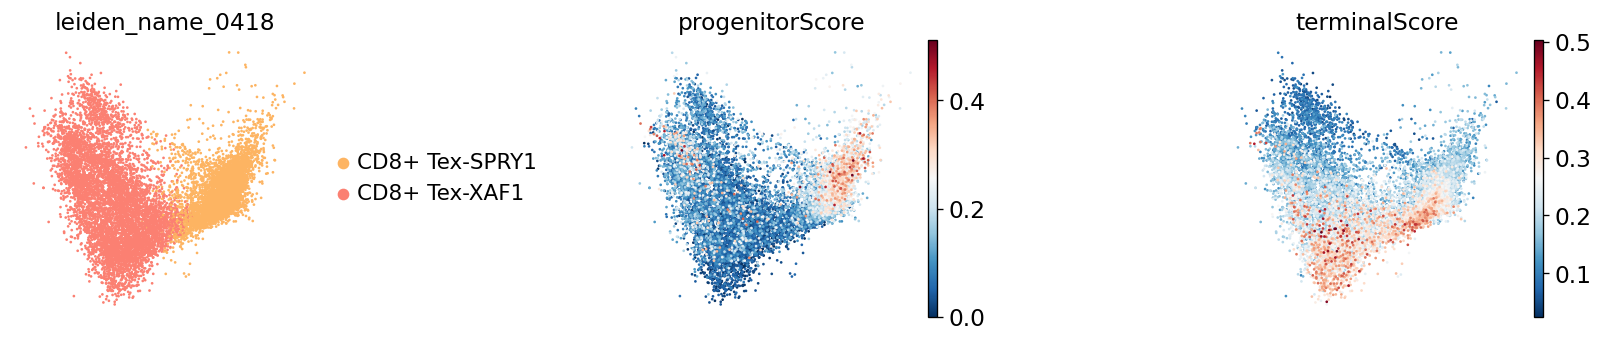

In [43]:
sc.pl.diffmap(cd8_tex, color=['leiden_name_0418','progenitorScore','terminalScore'],
              color_map='RdBu_r',components=['2,3'],wspace=0.8)

In [47]:
del cd8_tex.layers['Ms'], cd8_tex.layers['Mu'], cd8_tex.layers['variance_velocity'], cd8_tex.layers['velocity'], cd8_tex.layers['matrix']

In [48]:
dyn.pp.recipe_monocle(cd8_tex, n_top_genes=4000, fg_kwargs={"shared_count": 20})

|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----------> <insert> tkey to uns['pp'] in AnnData Object.
|-----------> <insert> experiment_type to uns['pp'] in AnnData Object.
|-----? dynamo detects your data is size factor normalized and/or log transformed. If this is not right, plese set `normalized = False.
|-----> filtering cells...
|-----> filtering genes...
|-----> calculating size factor...
|-----> selecting genes...
|-----> <insert> frac to var in AnnData Object.
|-----> <insert> X_spliced to

In [49]:
dyn.tl.dynamics(cd8_tex)

|-----> calculating first/second moments begins...
2022-12-05 10:39:48.115510: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
|
|-----> [moments calculation] finished [73.9352s]
estimating gamma: 100%|██████████| 2687/2687 [07:13<00:00,  6.20it/s]


AnnData object with n_obs × n_vars = 11526 × 21375
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'total_counts_hb', 'pct_counts_hb', 'total_counts_hsp', 'pct_counts_hsp', 'treat', 'sample', 'treat_sample', 'leiden', 'louvain', 'leiden_15', 'leiden_new', 'leiden_name', 'leiden_name_1102', 'group', 'leiden_name_1104', 'leiden_name_1204', 'sample_batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'terminal_states', 'terminal_states_probs', 'initial_states', 'initial_states_probs', 'leiden_name_0418', 'progenitorScore', 'terminalScore', 'cytoScore', 'IF-resp', 'Regulon(AGGF1(+))', 'Regulon(AHR(+))', 'Regulon(AHRR(+))', 'Regulon(AR(+))', 'Regulon(ARID3A(+))', 'Regulon(ARNT(+))', 'Regulon(ASCL1(+))', 'Regulon(ATF2(+))', 'Regulon(ATF3(+))', 'Regulon(ATF4(+))', 'Regulon(ATF6(+))', 'Regulon(ATF6B(+))', 'Regulon(

In [50]:
dyn.tl.reduceDimension(cd8_tex, n_pca_components=30)
dyn.tl.cell_velocities(cd8_tex, method="pearson", other_kernels_dict={"transform": "sqrt"})
dyn.tl.cell_velocities(cd8_tex, basis="pca")

|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|
|-----> [dimension_reduction projection] finished [0.0026s]
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [7.7908s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [2.4369s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 5.0321%

Using existing pearson_transition_matrix found in .obsp.


|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [3.1523s]


AnnData object with n_obs × n_vars = 11526 × 21375
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'total_counts_hb', 'pct_counts_hb', 'total_counts_hsp', 'pct_counts_hsp', 'treat', 'sample', 'treat_sample', 'leiden', 'louvain', 'leiden_15', 'leiden_new', 'leiden_name', 'leiden_name_1102', 'group', 'leiden_name_1104', 'leiden_name_1204', 'sample_batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'terminal_states', 'terminal_states_probs', 'initial_states', 'initial_states_probs', 'leiden_name_0418', 'progenitorScore', 'terminalScore', 'cytoScore', 'IF-resp', 'Regulon(AGGF1(+))', 'Regulon(AHR(+))', 'Regulon(AHRR(+))', 'Regulon(AR(+))', 'Regulon(ARID3A(+))', 'Regulon(ARNT(+))', 'Regulon(ASCL1(+))', 'Regulon(ATF2(+))', 'Regulon(ATF3(+))', 'Regulon(ATF4(+))', 'Regulon(ATF6(+))', 'Regulon(ATF6B(+))', 'Regulon(

In [60]:
cd8_tex.obsm['X_umap'] = cd8_tex.obsm['X_diffmap'][:,1:3]

<Figure size 600x400 with 0 Axes>

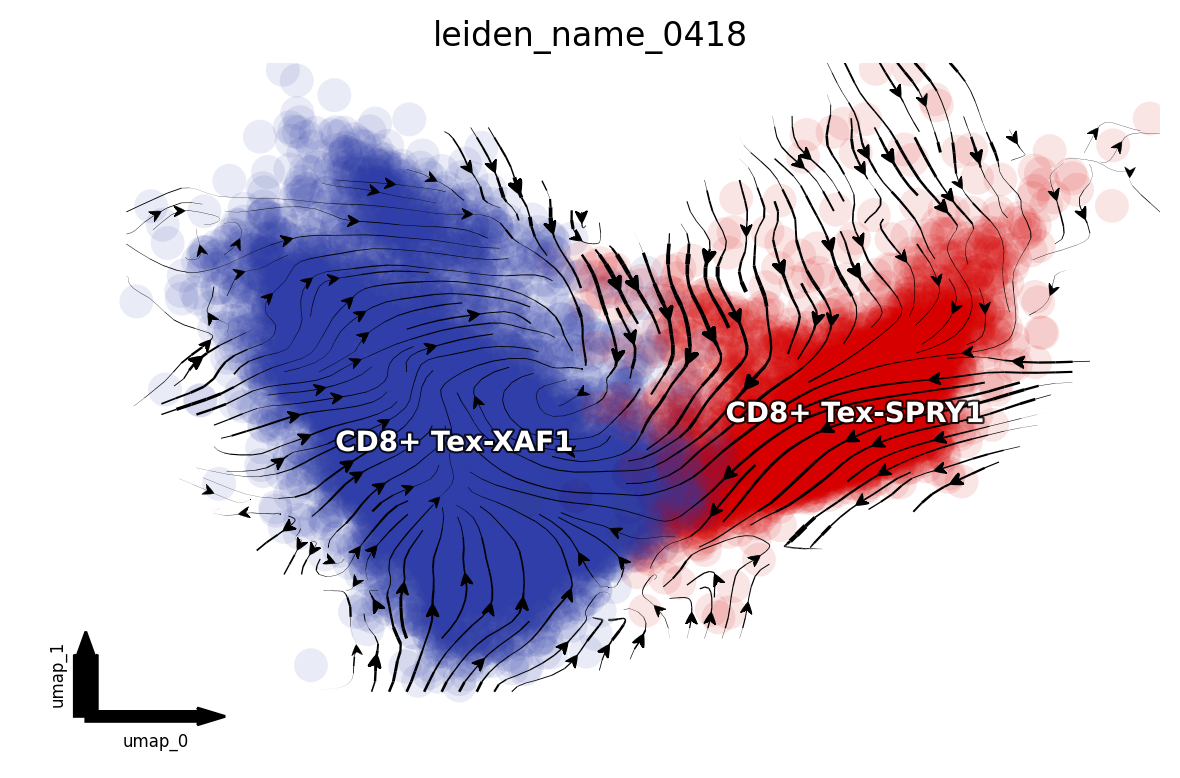

In [61]:
dyn.pl.streamline_plot(cd8_tex, color=["leiden_name_0418"], layer='X',
                       basis="umap", show_legend="on data", 
                       show_arrowed_spines=True,components=['2,3'])

In [ ]:
dyn.pl.scatters(cd8_tex, 
                x=np.repeat('umap_ddhodge_potential', 9), 
                pointsize=0.25, alpha=0.8, 
                y=['TCF7','SLAMF6','SPRY1'], layer='X_spliced', color='Cell_type',
                ncols=3, background='white', figsize=(7, 4))